In [72]:
import pickle
from pathlib import Path
import json
import io

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

In [29]:
labels = json.loads(Path('audioset/labels.json').read_text())

In [65]:
correlations = np.load(io.BytesIO(Path('audioset/correlations.npy').read_bytes()), allow_pickle=False)

In [ ]:
audioset_logits = pickle.loads(Path('tmp/audioset_logits.pkl').read_bytes())
audioset_span_average_probas = pickle.loads(Path('tmp/audioset_span_average_probas.pkl').read_bytes())

In [69]:
correlations = np.corrcoef(audioset_logits.data.T).astype(np.float16)

In [74]:
correlations_probas = np.corrcoef(expit(audioset_logits.data).T).astype(np.float16)

In [76]:
correlations_span_probas = np.corrcoef(audioset_span_average_probas.data.T).astype(np.float16)

In [62]:
labels[:10]

['Speech',
 'Male speech, man speaking',
 'Female speech, woman speaking',
 'Child speech, kid speaking',
 'Conversation',
 'Narration, monologue',
 'Babbling',
 'Speech synthesizer',
 'Shout',
 'Bellow']

In [70]:
correlations[1, 2]

0.4695

In [75]:
correlations_probas[1, 2]

-0.02534

In [77]:
correlations_span_probas[1, 2]

-0.04868

In [71]:
correlations[4, 5]

0.8564

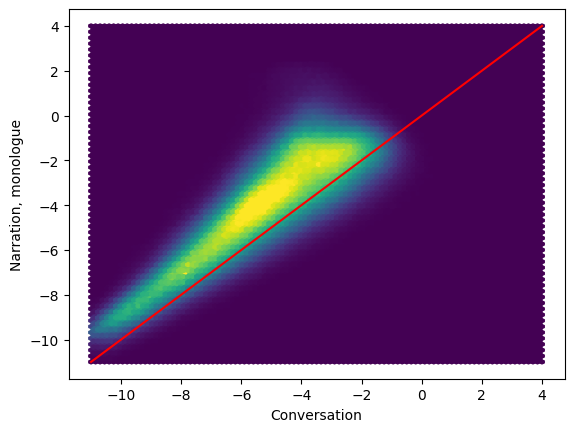

In [ ]:
cls1 = 'Conversation'
cls2 = 'Narration, monologue'

source = audioset_logits
# source = audioset_span_average_probas

if source is audioset_logits:
    extent = [[-11, 4], [-11, 4]]
else:
    extent = [[0, 1], [0, 1]]

x = source.data[:, labels.index(cls1)]
y = source.data[:, labels.index(cls2)]
plt.hexbin(x, y, vmax=5000, extent=extent[0] + extent[1])
plt.plot(*extent, color='r')
plt.xlabel(cls1)
plt.ylabel(cls2)
plt.show()

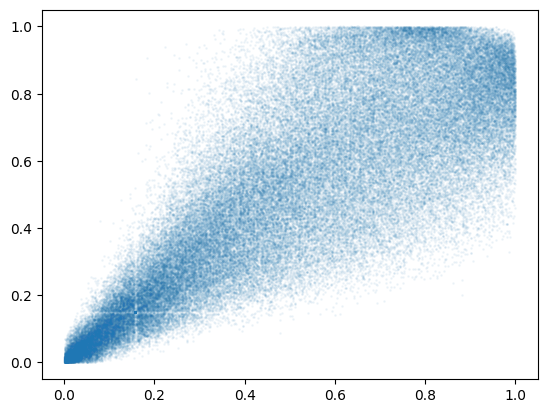

In [96]:
from sklearn.preprocessing import quantile_transform
plt.scatter(quantile_transform(x1[:, None])[:, 0], quantile_transform(x2[:, None])[:, 0], alpha=0.05, s=1)